# CH 7: Agentic Sales Pipeline

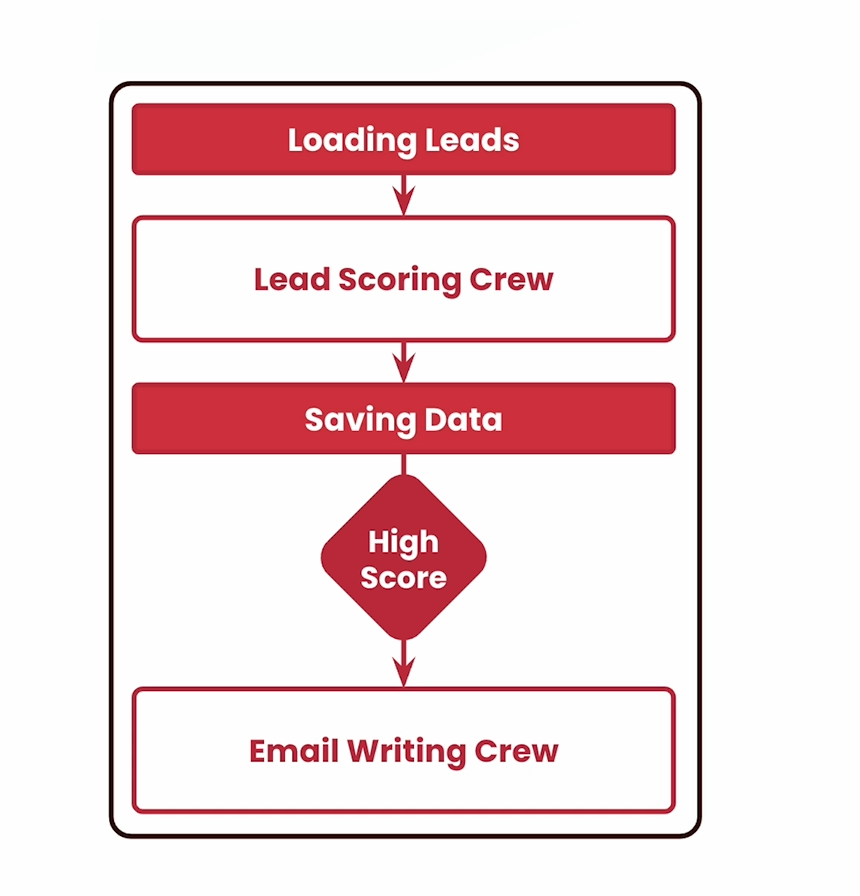

In [1]:
!pip install -qU crewai==0.75 crewai_tools==0.13.2 langchain_community==0.3.1

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/setuptools/dist.py:488: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              By 2025-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        opt = self.warn_dash_deprecatio

In [20]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Import libraries, API and LLM

In [21]:
import os
import yaml
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

In [22]:
# import os
# from utils import get_openai_api_key

# openai_api_key = get_openai_api_key()
# os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'


bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

## Loading Tasks and Agents YAML files

In [23]:
# Define file paths for YAML configurations
files = {
    'lead_agents': 'config/lead_qualification_agents.yaml',
    'lead_tasks': 'config/lead_qualification_tasks.yaml',
    'email_agents': 'config/email_engagement_agents.yaml',
    'email_tasks': 'config/email_engagement_tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
lead_agents_config = configs['lead_agents']
lead_tasks_config = configs['lead_tasks']
email_agents_config = configs['email_agents']
email_tasks_config = configs['email_tasks']

## Create Pydantic Models for Structured Output

In [24]:
from pydantic import BaseModel, Field
from typing import Dict, Optional, List, Set, Tuple

class LeadPersonalInfo(BaseModel):
    name: str = Field(..., description="The full name of the lead.")
    job_title: str = Field(..., description="The job title of the lead.")
    role_relevance: int = Field(..., ge=0, le=10, description="A score representing how relevant the lead's role is to the decision-making process (0-10).")
    professional_background: Optional[str] = Field(..., description="A brief description of the lead's professional background.")

class CompanyInfo(BaseModel):
    company_name: str = Field(..., description="The name of the company the lead works for.")
    industry: str = Field(..., description="The industry in which the company operates.")
    company_size: int = Field(..., description="The size of the company in terms of employee count.")
    revenue: Optional[float] = Field(None, description="The annual revenue of the company, if available.")
    market_presence: int = Field(..., ge=0, le=10, description="A score representing the company's market presence (0-10).")

class LeadScore(BaseModel):
    score: int = Field(..., ge=0, le=100, description="The final score assigned to the lead (0-100).")
    scoring_criteria: List[str] = Field(..., description="The criteria used to determine the lead's score.")
    validation_notes: Optional[str] = Field(None, description="Any notes regarding the validation of the lead score.")

class LeadScoringResult(BaseModel):
    personal_info: LeadPersonalInfo = Field(..., description="Personal information about the lead.")
    company_info: CompanyInfo = Field(..., description="Information about the lead's company.")
    lead_score: LeadScore = Field(..., description="The calculated score and related information for the lead.")

## Importing Tools

In [25]:
from crewai_tools import SerperDevTool, ScrapeWebsiteTool

## Lead Qualification Crew, Agents and Tasks

In [26]:
# Creating Agents
lead_data_agent = Agent(
  config=lead_agents_config['lead_data_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()],
  llm=llm
)

cultural_fit_agent = Agent(
  config=lead_agents_config['cultural_fit_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()],
    llm=llm
)

scoring_validation_agent = Agent(
  config=lead_agents_config['scoring_validation_agent'],
  tools=[SerperDevTool(), ScrapeWebsiteTool()],
    llm=llm
)

# Creating Tasks
lead_data_task = Task(
  config=lead_tasks_config['lead_data_collection'],
  agent=lead_data_agent
)

cultural_fit_task = Task(
  config=lead_tasks_config['cultural_fit_analysis'],
  agent=cultural_fit_agent
)

scoring_validation_task = Task(
  config=lead_tasks_config['lead_scoring_and_validation'],
  agent=scoring_validation_agent,
  context=[lead_data_task, cultural_fit_task],
  output_pydantic=LeadScoringResult
)

# Creating Crew
lead_scoring_crew = Crew(
  agents=[
    lead_data_agent,
    cultural_fit_agent,
    scoring_validation_agent
  ],
  tasks=[
    lead_data_task,
    cultural_fit_task,
    scoring_validation_task
  ],
  verbose=True
)

2025-01-03 11:23:12,572 - 140250410932032 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


## Email Engagement Crew

In [27]:
# Creating Agents
email_content_specialist = Agent(
  config=email_agents_config['email_content_specialist'],
    llm=llm
    
)

engagement_strategist = Agent(
  config=email_agents_config['engagement_strategist'],
    llm=llm
)

# Creating Tasks
email_drafting = Task(
  config=email_tasks_config['email_drafting'],
  agent=email_content_specialist,
    
)

engagement_optimization = Task(
  config=email_tasks_config['engagement_optimization'],
  agent=engagement_strategist
)

# Creating Crew
email_writing_crew = Crew(
  agents=[
    email_content_specialist,
    engagement_strategist
  ],
  tasks=[
    email_drafting,
    engagement_optimization
  ],
  verbose=True
)

2025-01-03 11:23:14,202 - 140250410932032 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


## Creating Complete Sales Flow

In [41]:
from crewai.flow.flow import Flow, listen, start

class SalesPipeline(Flow):
    @start()
    def fetch_leads(self):
        # Pull our leads from the database
        leads = [
            {
                "lead_data": {
                    "name": "João Moura",
                    "job_title": "Director of Engineering",
                    "company": "Clearbit",
                    "email": "joao@clearbit.com",
                    "use_case": "Using AI Agent to do better data enrichment."
                },
            },
        ]
        return leads

    @listen(fetch_leads)
    def score_leads(self, leads):
        scores = lead_scoring_crew.kickoff_for_each(leads)
        self.state["score_crews_results"] = scores
        return scores

    @listen(score_leads)
    def store_leads_score(self, scores):
        # Here we would store the scores in the database
        return scores

    @listen(score_leads)
    def filter_leads(self, scores):
        return [score for score in scores if score['lead_score'].score > 70]

    @listen(filter_leads)
    def write_email(self, leads):
        scored_leads = [lead.to_dict() for lead in leads]
        emails = email_writing_crew.kickoff_for_each(scored_leads)
        return emails

    @listen(write_email)
    def send_email(self, emails):
        # Here we would send the emails to the leads
        return emails
    
flow = SalesPipeline()

AttributeError: 'Telemetry' object has no attribute 'flow_creation_span'

## Plotting the Flow

In [42]:
flow.plot()

NameError: name 'flow' is not defined

In [39]:
from IPython.display import IFrame

IFrame(src='./crewai_flow.html', width='150%', height=600)

## Flow Kickoff

In [ ]:
emails = await flow.kickoff()

## Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [ ]:
import pandas as pd

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([flow.state["score_crews_results"][0].token_usage.dict()])

# Calculate total costs
costs = 0.150 * df_usage_metrics['total_tokens'].sum() / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Display the DataFrame
df_usage_metrics

In [ ]:
import pandas as pd

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([emails[0].token_usage.dict()])

# Calculate total costs
costs = 0.150 * df_usage_metrics['total_tokens'].sum() / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Display the DataFrame
df_usage_metrics

## Inspecting Results

In [33]:
scores = flow.state["score_crews_results"]

NameError: name 'flow' is not defined

In [40]:
import pandas as pd
from IPython.display import display, HTML

lead_scoring_result = scores[0].pydantic

# Create a dictionary with the nested structure flattened
data = {
    'Name': lead_scoring_result.personal_info.name,
    'Job Title': lead_scoring_result.personal_info.job_title,
    'Role Relevance': lead_scoring_result.personal_info.role_relevance,
    'Professional Background': lead_scoring_result.personal_info.professional_background,
    'Company Name': lead_scoring_result.company_info.company_name,
    'Industry': lead_scoring_result.company_info.industry,
    'Company Size': lead_scoring_result.company_info.company_size,
    'Revenue': lead_scoring_result.company_info.revenue,
    'Market Presence': lead_scoring_result.company_info.market_presence,
    'Lead Score': lead_scoring_result.lead_score.score,
    'Scoring Criteria': ', '.join(lead_scoring_result.lead_score.scoring_criteria),
    'Validation Notes': lead_scoring_result.lead_score.validation_notes
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index', columns=['Value'])

# Reset the index to turn the original column names into a regular column
df = df.reset_index()

# Rename the index column to 'Attribute'
df = df.rename(columns={'index': 'Attribute'})

# Create HTML table with bold attributes and left-aligned values
html_table = df.style.set_properties(**{'text-align': 'left'}) \
                     .format({'Attribute': lambda x: f'<b>{x}</b>'}) \
                     .hide(axis='index') \
                     .to_html()

# Display the styled HTML table
display(HTML(html_table))

NameError: name 'scores' is not defined

## Results

In [34]:
import textwrap

result_text = emails[0].raw
wrapped_text = textwrap.fill(result_text, width=80)
print(wrapped_text)

NameError: name 'emails' is not defined

## How Complex Can it Get?

In [35]:
from crewai import Flow
from crewai.flow.flow import listen, start, and_, or_, router

class SalesPipeline(Flow):
    
  @start()
  def fetch_leads(self):
    # Pull our leads from the database
    # This is a mock, in a real-world scenario, this is where you would
    # fetch leads from a database
    leads = [
      {
        "lead_data": {
          "name": "João Moura",
          "job_title": "Director of Engineering",
          "company": "Clearbit",
          "email": "joao@clearbit.com",
          "use_case": "Using AI Agent to do better data enrichment."
        },
      },
    ]
    return leads

  @listen(fetch_leads)
  def score_leads(self, leads):
    scores = lead_scoring_crew.kickoff_for_each(leads)
    self.state["score_crews_results"] = scores
    return scores

  @listen(score_leads)
  def store_leads_score(self, scores):
    # Here we would store the scores in the database
    return scores

  @listen(score_leads)
  def filter_leads(self, scores):
    return [score for score in scores if score['lead_score'].score > 70]

  @listen(and_(filter_leads, store_leads_score))
  def log_leads(self, leads):
    print(f"Leads: {leads}")

  @router(filter_leads, paths=["high", "medium", "low"])
  def count_leads(self, scores):
    if len(scores) > 10:
      return 'high'
    elif len(scores) > 5:
      return 'medium'
    else:
      return 'low'

  @listen('high')
  def store_in_salesforce(self, leads):
    return leads

  @listen('medium')
  def send_to_sales_team(self, leads):
    return leads

  @listen('low')
  def write_email(self, leads):
    scored_leads = [lead.to_dict() for lead in leads]
    emails = email_writing_crew.kickoff_for_each(scored_leads)
    return emails

  @listen(write_email)
  def send_email(self, emails):
    # Here we would send the emails to the leads
    return emails

ImportError: cannot import name 'Flow' from 'crewai' (/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/crewai/__init__.py)

## Plotting the Flow

In [36]:
flow = SalesPipeline()
flow.plot()

AttributeError: 'Telemetry' object has no attribute 'flow_creation_span'

In [37]:
from IPython.display import IFrame

IFrame(src='./crewai_flow_complex.html', width='150%', height=600)